# Support Vector Machine - Test Features
This notebook tests feature and ideas from 'Evaluating Segmentation Error Without Ground Truth' by Kohlberger et al.

author = Caroline Magg <br>
date = 18 August 2020 <br> 

______________________________________
history: <br>
2020-18-08, 19-08, 26-08, 27-08 Features <br>
2020-27-08 Testing SVM independent Features

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import scipy
import logging as log
import skimage.segmentation as segmentation
from scipy.spatial.distance import cdist

In [2]:
log.basicConfig(format='%(levelname)s:%(message)s', level=log.INFO)

### Add dependencies

In [3]:
# add KidsBrainProject main folder to paths
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../utils/'))

In [4]:
# add path to data here
path_data = "../../Data/" 

data_brain = pd.read_csv("../../Data/data_Brain.csv")

# Features

## Synthetic data

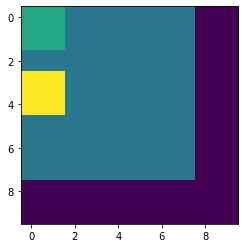

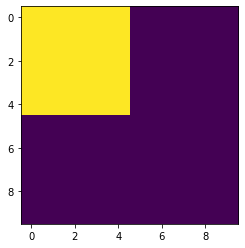

In [5]:
test = np.zeros((10,10))
test[:8,:8] = 2
test[3:5,:2] = 5
test[:2,:2] = 3
test_segm = np.zeros((10,10))
test_segm[:5,:5]=1
plt.imshow(test), np.sum(test)
plt.show()
plt.imshow(test_segm)

## Real Test data

In [6]:
df = pd.read_csv("../../Data/data_Brain.csv", delimiter=';')
df.head()

,PatientID,Img,Init,Segm,Slice,RoiName
0,1,../../Data/1/Segmentation/png/1_slice28.png,../../Data/1/Segmentation/init/1_init_Brain_sl...,../../Data/1/Segmentation/t0/1_t0_Brain_slice2...,28,Brain
1,1,../../Data/1/Segmentation/png/1_slice29.png,../../Data/1/Segmentation/init/1_init_Brain_sl...,../../Data/1/Segmentation/t0/1_t0_Brain_slice2...,29,Brain
2,1,../../Data/1/Segmentation/png/1_slice30.png,../../Data/1/Segmentation/init/1_init_Brain_sl...,../../Data/1/Segmentation/t0/1_t0_Brain_slice3...,30,Brain
3,1,../../Data/1/Segmentation/png/1_slice31.png,../../Data/1/Segmentation/init/1_init_Brain_sl...,../../Data/1/Segmentation/t0/1_t0_Brain_slice3...,31,Brain
4,1,../../Data/1/Segmentation/png/1_slice32.png,../../Data/1/Segmentation/init/1_init_Brain_sl...,../../Data/1/Segmentation/t0/1_t0_Brain_slice3...,32,Brain


In [7]:
df2 = df[df['PatientID']==1][:-1]
df2.tail()

,PatientID,Img,Init,Segm,Slice,RoiName
124,1,../../Data/1/Segmentation/png/1_slice152.png,../../Data/1/Segmentation/init/1_init_Brain_sl...,../../Data/1/Segmentation/t0/1_t0_Brain_slice1...,152,Brain
125,1,../../Data/1/Segmentation/png/1_slice153.png,../../Data/1/Segmentation/init/1_init_Brain_sl...,../../Data/1/Segmentation/t0/1_t0_Brain_slice1...,153,Brain
126,1,../../Data/1/Segmentation/png/1_slice154.png,../../Data/1/Segmentation/init/1_init_Brain_sl...,../../Data/1/Segmentation/t0/1_t0_Brain_slice1...,154,Brain
127,1,../../Data/1/Segmentation/png/1_slice155.png,../../Data/1/Segmentation/init/1_init_Brain_sl...,../../Data/1/Segmentation/t0/1_t0_Brain_slice1...,155,Brain
128,1,../../Data/1/Segmentation/png/1_slice156.png,../../Data/1/Segmentation/init/1_init_Brain_sl...,../../Data/1/Segmentation/t0/1_t0_Brain_slice1...,156,Brain


In [8]:
list_of_segm_mask = [cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in df2['Init']]
list_of_img = [cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in df2['Img']]

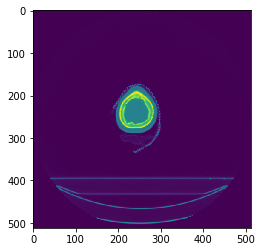

In [9]:
plt.imshow(list_of_img[2])

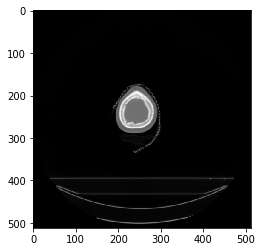

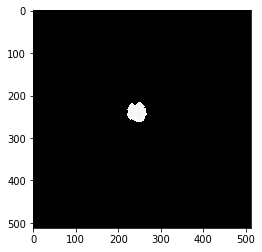

In [10]:
idx = 2
segm = list_of_segm_mask[idx]
img = list_of_img[idx].copy()
plt.imshow(img, cmap='gray')
plt.show()
img[segm==0] = 0
plt.imshow(img, cmap='gray')

In [11]:
np.unique(img)

array([  0, 110, 111, 112, 113, 114, 115, 116], dtype=uint8)

In [12]:
mask = img.copy()

## Geometric features - 3 Features
measure of size of the segmentation masks

#### Volume
number of voxels in mask

In [13]:
volume = np.sum(test_segm==1)
volume

25

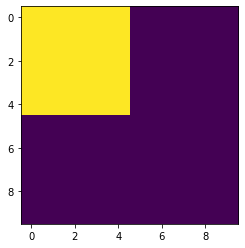

In [14]:
plt.imshow(test_segm)

#### Surface Area 
number of edges on boundary of segmentation (assuming a graph structure with a 6-connected lattice) <br>
~ number of pixels at contour

16


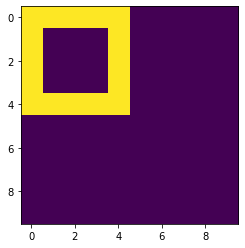

In [15]:
im3, contours, hierarchy = cv2.findContours(test_segm.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
processed = cv2.drawContours(np.zeros_like(im3), contours, -1, 1, 1)
print(np.sum(processed==1))
plt.imshow(processed)

#### Total Curvature
sum of mean curvature on surface <br>
mean curvature 

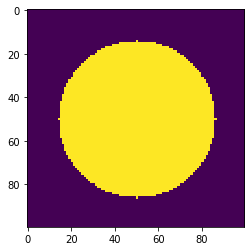

In [16]:
test2 = np.zeros((100,100))
cv2.circle(test2, (50,50), 36, (1,0,0), -1)
plt.imshow(test2)

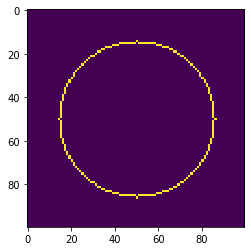

In [17]:
im3, contours, hierarchy = cv2.findContours(test2.astype(np.uint8),cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
processed = cv2.drawContours(np.zeros_like(im3), contours, -1, 255, 1)
plt.imshow(processed)

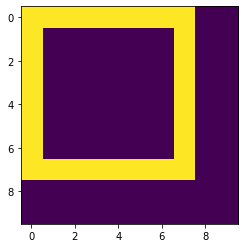

In [18]:
im3, contours, hierarchy = cv2.findContours(test.astype(np.uint8),cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
processed = cv2.drawContours(np.zeros_like(im3), contours, -1, 255, 1)
plt.imshow(processed)

In [19]:
points = []
for i in range(contours[0].shape[1]):
    points.append(contours[0][:,i,:])

In [20]:
#first derivatives 
dx= np.gradient(points[0][:,0])
dy = np.gradient(points[0][:,1])

#second derivatives 
d2x = np.gradient(dx)
d2y = np.gradient(dy)

mean_curvature = np.abs(d2x * dy - dx * d2y) / (dx * dx + dy * dy)**1.5
curvature = np.sum(mean_curvature)
curvature

5.742640687119285

In [21]:
mean_curvature

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.25      , 1.41421356, 0.25      , 0.        ,
       0.        , 0.        , 0.        , 0.25      , 1.41421356,
       0.25      , 0.        , 0.        , 0.        , 0.        ,
       0.25      , 1.41421356, 0.25      , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

C:\Users\Caroline\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


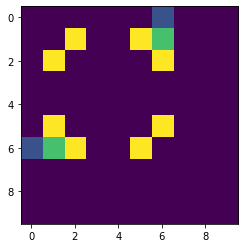

In [22]:
dx, dy = np.gradient(processed)
d2x, dxy = np.gradient(dx)
dyx, d2y = np.gradient(dy)
mean_curvature = np.abs(d2x * dy - dx * d2y) / ((dx * dx + dy * dy)**1.5)
mean_curvature[np.isnan(mean_curvature)] = 0

plt.imshow(mean_curvature)

In [23]:
mean_curvature

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00098039, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00392157, 0.        , 0.        ,
        0.00392157, 0.00277297, 0.        , 0.        , 0.        ],
       [0.        , 0.00392157, 0.        , 0.        , 0.        ,
        0.        , 0.00392157, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00392157, 0.        , 0.        , 0.        ,
        0.        , 0.00392157, 0.        , 0.        , 0.        ],
       [0.00098039, 0.00277297, 0.00392157, 0.        , 0.        ,
        0.00392157, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [24]:
np.sum(mean_curvature)

0.03887926887205135

## Weighted geometric features
locally emphasized when intensity values are similar to each other, suppressed when local intensity values are dissimilar to each other

In [ ]:
from numpy.linalg import norm

In [ ]:
def cauchy_function(i1, i2, M, beta=10^4):
    return 1/(1+beta*((i1-i2)/M)**2)
def cauchy_function_plus(i1, i2, M, beta=10^4):
    if i1 > i2:
        return cauchy_function(i1, i2, M, beta)
    else:
        return 1
def cauchy_function_minus(i1, i2, M, beta=10^4):
    if i1 > i2:
        return 1
    else:
        return cauchy_function(i1, i2, M, beta)

### Test data

In [ ]:
plt.imshow(test), test

In [ ]:
gradients = np.abs(np.gradient(test)[0])+np.abs(np.gradient(test)[1])
gradients

In [ ]:
plt.imshow(gradients)

In [ ]:
M = max((np.abs(np.gradient(test)[0]) + np.abs(np.gradient(test)[1]))[test_segm==1])
M

In [ ]:
3/M, 2/M, 1/M

In [ ]:
cauchy_function(0,1,M), cauchy_function(0,2,M), cauchy_function(0,3,M)

In [ ]:
cauchy_function_plus(0,2,M), cauchy_function_plus(2,0,M), cauchy_function_minus(0,2,M), cauchy_function_minus(2,0,M)

In [ ]:
def weight_edges_full_neighborhood(batch, M, i=1, j=1):
    s = 0
    counter = 0
    v = batch[i,j]
    for r in range(0,batch.shape[0]):
        for c in range(0,batch.shape[1]):
            if r == i and c == j:
                continue 
            else:
                s = s + cauchy_function(v,batch[r,c],M)
                counter += 1
    #print(counter)
    return s/counter

In [ ]:
def weight_edges_4neighborhood(batch, M, i=1, j=1):
    s = 0
    v = batch[i,j]
    counter = 0
    for r in range(0,batch.shape[0]):
        for c in range(0,batch.shape[1]):
            if r == i and c == j:
                continue 
            elif r == i or c == j:
                s = s + cauchy_function(v,batch[r,c],M)
                counter += 1
    #print(counter)
    return s/counter

In [ ]:
def weight_edges_4neighborhood_boundary(batch, batch_segm, M, i=1, j=1):
    s = 0
    v = batch[i,j]
    counter = 0
    for r in range(0,batch.shape[0]):
        for c in range(0,batch.shape[1]):
            if r == i and c == j:
                continue 
            elif (r == i or c == j) and ~batch_segm[r,c]:
                s = s + cauchy_function(v,batch[r,c],M)
                counter += 1
    if counter == 0:
        return counter
    else:
        return s/counter

In [ ]:
weight_edges_full_neighborhood(test[:3,:3],M,i=1,j=1)

In [ ]:
weight_edges_4neighborhood(test[:3,:3],M,i=1,j=1)

In [ ]:
(cauchy_function(3,3,M)*3+cauchy_function(3,2,M)*5)/8, (cauchy_function(3,3,M)*2+cauchy_function(3,2,M)*2)/4

In [ ]:
blub = np.zeros((3,3))
blub[:2,:2] = 1
blub[:2,:2] = 1
plt.imshow(blub)

In [ ]:
test[:3,:3], blub

In [ ]:
print(weight_edges_4neighborhood_boundary(test[:3,:3],blub==1,M,i=1,j=1))
print(weight_edges_4neighborhood_boundary(test[:2,:3],blub==1,M,i=0,j=1))
print(weight_edges_4neighborhood_boundary(test[:2,:2],blub==1,M,i=0,j=0))

In [ ]:
(cauchy_function(3,2,M)*2)/2, (cauchy_function(3,2,M))

#### weighted volume
sum over the weights of all voxels

In [ ]:
def _calc_weighted_volume(batch, batch_segm, M):
    weighted_volume = 0
    for i in range(batch.shape[0]):
        for j in range(batch.shape[1]):
            if batch_segm[i,j]:  # voxel inside segmentation
                # 3x3 or 2x2 or 2x3 or 3x2 part of batch
                idx1 = max(0,i-1)
                idx2 = min(batch.shape[0], i+2)
                idx3 = max(0,j-1)
                idx4 = min(batch.shape[1], j+2)                
                if i==batch.shape[0]:
                    idx1=i-2
                if j==batch.shape[1]:
                    idx3=i-2                    
                b = batch[idx1:idx2, idx3:idx4]
                # sum up edges weights
                if (i==0 and j==batch.shape[1]) or (i==batch.shape[0] and j==0) or (i==0 and j==0) or (i==batch.shape[0] and j==batch.shape[1]): # corner
                    weighted_volume += weight_edges_4neighborhood(b, M, min(i,1), min(j,1))
                elif i == 0 or j == 0 or i == batch.shape[0] or j == batch.shape[1]: # border
                    weighted_volume += weight_edges_4neighborhood(b, M, min(i,1), min(j,1))
                else:  # interior
                    weighted_volume += weight_edges_4neighborhood(b, M, 1, 1)
    return weighted_volume

In [ ]:
weighted_volume = _calc_weighted_volume(test, test_segm==1, M)
weighted_volume

##### testing

In [ ]:
test_segm=np.zeros_like(test_segm)
test_segm[:3,:3] = 1
plt.imshow(test_segm[:4,:4])

In [ ]:
_calc_weighted_volume(test[:4,:4], test_segm[:4,:4], M)

In [ ]:
test[:4,:4]

In [ ]:
# control
s = 0
s+=cauchy_function(3,3,M)*2/2 #00
print(s)
s+=(cauchy_function(3,3,M)*2+cauchy_function(2,3,M))/3 # 01
print(s)
s+=(cauchy_function(2,3,M)+cauchy_function(2,2,M)*2)/3 # 02
print(s)
s+=(cauchy_function(3,3,M)*2+cauchy_function(3,2,M))/3 # 10
print(s)
s+=(cauchy_function(3,3,M)*2+cauchy_function(3,2,M)*2)/4 # 11
print(s)
s+=(cauchy_function(2,2,M)*3+cauchy_function(3,2,M))/4 # 12
print(s)
s+=(cauchy_function(3,2,M)+cauchy_function(2,2,M)+cauchy_function(2,5,M))/3 # 20 
print(s)
s+=(cauchy_function(2,2,M)*2+cauchy_function(3,2,M)+cauchy_function(2,5,M))/4 # 21
print(s)
s+=(cauchy_function(2,2,M)*4)/4 # 22
s

In [ ]:
test_segm=np.zeros_like(test_segm)
test_segm[:5,:5] = 1

#### weighted cut
sum over all edge weights along boundary of segmentation

In [ ]:
# 4-neighborhood
def _calc_weighted_cut(batch, batch_segm, M):
    weighted_cut = 0
    for i in range(batch.shape[0]):
        for j in range(batch.shape[1]):
            if batch_segm[i,j]==1:  # voxel inside segmentation & on boundary
                idx1 = max(0,i-1)
                idx2 = min(batch.shape[0], i+2)
                idx3 = max(0,j-1)
                idx4 = min(batch.shape[1], j+2)                
                if i==batch.shape[0]:
                    idx1=i-2
                if j==batch.shape[1]:
                    idx3=i-2            
                for r in range(idx1,idx2):
                    for c in range(idx3,idx4):
                        if r != i and j != c:
                            continue
                        elif (r==i or j==c) and batch_segm[r,c]==0:  # not vertex and not inside segmentation
                            weighted_cut += cauchy_function(batch[i,j],batch[r,c],M)
                            #print(weighted_cut)
    return weighted_cut

In [ ]:
weighted_cut = _calc_weighted_cut(test, test_segm==1, M)
weighted_cut

##### testing

In [ ]:
test_segm=np.zeros_like(test_segm)
test_segm[:3,:3] = 1
plt.imshow(test_segm[:4,:4])
plt.show()

In [ ]:
im3, contours, hierarchy = cv2.findContours(test[:4,:4].astype(np.uint8),cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
processed = cv2.drawContours(np.zeros_like(im3), contours, -1, 1, 1)
plt.imshow(processed)

In [ ]:
_calc_weighted_cut(test[:4,:4], test_segm[:4,:4]==1, M)

In [ ]:
test[:4,:4], test_segm[:4,:4], processed

In [ ]:
# control
s=0
s+=cauchy_function(2,2,M) # 0
print(s)
s+=cauchy_function(2,2,M) # 1
print(s)
s+=cauchy_function(2,5,M) # 20
print(s)
s+=cauchy_function(2,5,M) # 21
print(s)
s+=cauchy_function(2,2,M) # 22
print(s)
s+=cauchy_function(2,2,M) # 22
s

In [ ]:
test_segm=np.zeros_like(test_segm)
test_segm[:5,:5] = 1

#### weighted curvature
sum of mean curvature weighted by local edge weight

In [ ]:
im3, contours, hierarchy = cv2.findContours(test.astype(np.uint8),cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
processed = cv2.drawContours(np.zeros_like(im3), contours, -1, 255, 1)
plt.imshow(processed)

In [ ]:
dx, dy = np.gradient(processed)
d2x, dxy = np.gradient(dx)
dyx, d2y = np.gradient(dy)
mean_curvature = np.abs(d2x * dy - dx * d2y) / ((dx * dx + dy * dy)**1.5)
mean_curvature[np.isnan(mean_curvature)] = 0

plt.imshow(mean_curvature)

In [ ]:
def _calc_weighted_curvature(batch, batch_segm, M):
    # mean curvature matrix
    im3, contours, hierarchy = cv2.findContours(batch.astype(np.uint8),cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    processed = cv2.drawContours(np.zeros_like(im3), contours, -1, 1, 1)
    dx, dy = np.gradient(processed)
    d2x, dxy = np.gradient(dx)
    dyx, d2y = np.gradient(dy)
    mean_curvature = np.abs(d2x * dy - dx * d2y) / ((dx * dx + dy * dy)**1.5)
    mean_curvature[np.isnan(mean_curvature)] = 0
    # sum and weighted but component
    weighted_cut = 0
    for i in range(batch.shape[0]):
        for j in range(batch.shape[1]):
            if batch_segm[i,j]==1:  # voxel inside segmentation & on boundary
                idx1 = max(0,i-1)
                idx2 = min(batch.shape[0], i+2)
                idx3 = max(0,j-1)
                idx4 = min(batch.shape[1], j+2)                
                if i==batch.shape[0]:
                    idx1=i-2
                if j==batch.shape[1]:
                    idx3=i-2            
                for r in range(idx1,idx2):
                    for c in range(idx3,idx4):
                        if r != i and j != c and batch_segm[r,c]==0:  # not vertex and not inside segmentation
                            weighted_cut += cauchy_function(batch[i,j],batch[r,c],M)*mean_curvature[r,c]
                            #print(weighted_cut)
    return weighted_cut

In [ ]:
im3, contours, hierarchy = cv2.findContours(test.astype(np.uint8),cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
processed = cv2.drawContours(np.zeros_like(im3), contours, -1, 1, 1)
dx, dy = np.gradient(processed)
d2x, dxy = np.gradient(dx)
dyx, d2y = np.gradient(dy)
mean_curvature = np.abs(d2x * dy - dx * d2y) / ((dx * dx + dy * dy)**1.5)
mean_curvature[np.isnan(mean_curvature)] = 0

In [ ]:
plt.imshow(mean_curvature*test_segm==1)

In [ ]:
np.where(mean_curvature*test_segm==1)

In [ ]:
test_segm[2,1]

In [ ]:
weighted_curvature = _calc_weighted_curvature(test, test_segm==1, M)

In [ ]:
weighted_curvature

#### low-hi weighted cut and hi-low weighted cut
along segmentation boundary edges

In [ ]:
# 4-neighborhood
def _calc_low_hi_weighted_cut(batch, batch_segm, M):
    weighted_cut = 0
    for i in range(batch.shape[0]):
        for j in range(batch.shape[1]):
            if batch_segm[i,j]==1:  # voxel inside segmentation & on boundary
                idx1 = max(0,i-1)
                idx2 = min(batch.shape[0], i+2)
                idx3 = max(0,j-1)
                idx4 = min(batch.shape[1], j+2)                
                if i==batch.shape[0]:
                    idx1=i-2
                if j==batch.shape[1]:
                    idx3=i-2            
                for r in range(idx1,idx2):
                    for c in range(idx3,idx4):
                        if r != i and j != c:
                            continue
                        elif (r==i or j==c) and batch_segm[r,c]==0:  # not vertex and not inside segmentation
                            weighted_cut += cauchy_function_plus(batch[i,j],batch[r,c],M)
                            #print(weighted_cut)
    return weighted_cut

In [ ]:
# 4-neighborhood
def _calc_hi_low_weighted_cut(batch, batch_segm, M):
    weighted_cut = 0
    for i in range(batch.shape[0]):
        for j in range(batch.shape[1]):
            if batch_segm[i,j]==1:  # voxel inside segmentation & on boundary
                idx1 = max(0,i-1)
                idx2 = min(batch.shape[0], i+2)
                idx3 = max(0,j-1)
                idx4 = min(batch.shape[1], j+2)                
                if i==batch.shape[0]:
                    idx1=i-2
                if j==batch.shape[1]:
                    idx3=i-2            
                for r in range(idx1,idx2):
                    for c in range(idx3,idx4):
                        if r != i and j != c:
                            continue
                        elif (r==i or j==c) and batch_segm[r,c]==0:  # not vertex and not inside segmentation
                            weighted_cut += cauchy_function_minus(batch[i,j],batch[r,c],M)
                            #print(weighted_cut)
    return weighted_cut

In [ ]:
_calc_low_hi_weighted_cut(test, test_segm==1, M), _calc_hi_low_weighted_cut(test, test_segm==1, M)

#### testing

In [ ]:
test_segm=np.zeros_like(test_segm)
test_segm[:3,:3] = 1
plt.imshow(test_segm[:4,:4])
plt.show()

In [ ]:
test[:4,:4], test_segm[:4,:4]

In [ ]:
_calc_low_hi_weighted_cut(test[:4,:4], test_segm[:4,:4]==1, M), _calc_hi_low_weighted_cut(test[:4,:4], test_segm[:4,:4]==1, M)

In [ ]:
# control
s=0
s+=cauchy_function_plus(2,2,M) # 0
print(s)
s+=cauchy_function_plus(2,2,M) # 1
print(s)
s+=cauchy_function_plus(2,5,M) # 20
print(s)
s+=cauchy_function_plus(2,5,M) # 21
print(s)
s+=cauchy_function_plus(2,2,M) # 22
print(s)
s+=cauchy_function_plus(2,2,M) # 22
s

In [ ]:
# control
s=0
s+=cauchy_function_minus(2,2,M) # 0
print(s)
s+=cauchy_function_minus(2,2,M) # 1
print(s)
s+=cauchy_function_minus(2,5,M) # 20
print(s)
s+=cauchy_function_minus(2,5,M) # 21
print(s)
s+=cauchy_function_minus(2,2,M) # 22
print(s)
s+=cauchy_function_minus(2,2,M) # 22
s

In [ ]:
test_segm=np.zeros_like(test_segm)
test_segm[:5,:5] = 1

## Intensity - 7 Features

### Test data

#### mean, median, max, min, sum intensity

In [ ]:
mean_intensity = np.mean(test[test_segm==1])
median_intensity = np.median(test[test_segm==1])
min_intensity = np.min(test[test_segm==1])
max_intensity = np.max(test[test_segm==1])
sum_intensity = np.sum(test[test_segm==1])
mean_intensity, median_intensity, min_intensity, max_intensity, sum_intensity

In [ ]:
test[test_segm==1]

#### interquartile distance and standard deviation

In [ ]:
iqr_distance = np.subtract(*np.percentile(test[test_segm==1], [75, 25]))/2
std = np.std(test[test_segm==1])
iqr_distance, std, np.percentile(test[test_segm==1], [75, 25])

### Real data

#### mean, median, max, min, sum intensity

In [ ]:
mean_intensity = np.mean(mask[segm==1])
median_intensity = np.median(mask[segm==1])
min_intensity = np.min(mask[segm==1])
max_intensity = np.max(mask[segm==1])
mean_intensity, median_intensity, min_intensity, max_intensity, sum_intensity

#### interquartile distance and standard deviation

In [ ]:
iqr_distance = np.subtract(*np.percentile(mask[segm==1], [75, 25]))/2
std = np.std(mask[segm==1])
iqr_distance, std

## Gradient - 10 Features

### Test data

#### L1 norm of intensities

In [ ]:
sum_l1 = np.sum(np.abs(np.gradient(test)[0])+np.abs(np.gradient(test)[1]))
sum_l1, np.sum(np.abs(np.gradient(test)[0].flatten()) + np.abs(np.gradient(test)[1].flatten()))

In [ ]:
np.sum((np.abs(np.gradient(test)[0])+np.abs(np.gradient(test)[1]))[test_segm==1])

In [ ]:
mean_l1 = np.sum((np.abs(np.gradient(test)[0])+np.abs(np.gradient(test)[1]))[test_segm==1])/np.sum(test_segm)
median_l1 = np.median((np.abs(np.gradient(test)[0])+np.abs(np.gradient(test)[1]))[test_segm==1])
min_l1 = np.min((np.abs(np.gradient(test)[0])+np.abs(np.gradient(test)[1]))[test_segm==1])
max_l1 = np.max((np.abs(np.gradient(test)[0])+np.abs(np.gradient(test)[1]))[test_segm==1])
mean_l1, median_l1, min_l1, max_l1,

In [ ]:
std_l1 = np.std((np.abs(np.gradient(test)[0])+np.abs(np.gradient(test)[1]))[test_segm==1])
iqd_l1 = np.subtract(*np.percentile((np.abs(np.gradient(test)[0])+np.abs(np.gradient(test)[1]))[test_segm==1], [75, 25]))/2
std_l1, iqd_l1

#### L2 norm of intensities

In [ ]:
sum_l2 = np.sum(np.sqrt((np.gradient(test)[0])**2+(np.gradient(test)[1])**2))
sum_l2, np.sum(np.sqrt((np.gradient(test)[0].flatten())**2+(np.gradient(test)[1].flatten())**2))

In [ ]:
np.sum(np.sqrt((np.gradient(test)[0])**2+(np.gradient(test)[1])**2)[test_segm==1])

In [ ]:
mean_l2 = np.sum(np.sqrt((np.gradient(test)[0])**2+(np.gradient(test)[1])**2))/np.sum(test_segm)
std_l2 = np.std(np.sqrt((np.gradient(test)[0])**2+(np.gradient(test)[1])**2)[test_segm==1])
mean_l2, std_l2

In [ ]:
np.linalg.norm(np.array([np.gradient(test)[0].flatten(), np.gradient(test)[1].flatten()])) # sum

### Real data

In [ ]:
gradients = np.abs(np.gradient(mask)[0])+np.abs(np.gradient(mask)[1])
gradients[segm==0] = 0
plt.imshow(gradients)

In [ ]:
np.unique(np.gradient(mask)[0]), np.unique(np.gradient(mask)[1]) 

In [ ]:
np.unique(gradients)

In [ ]:
gradients

#### L1 intensity gradients

In [ ]:
sum_l1 = np.sum(np.abs(np.gradient(mask)[0])+np.abs(np.gradient(mask)[1]))
sum_l1

In [ ]:
mean_l1 = np.sum(np.abs(np.gradient(mask)[0])+np.abs(np.gradient(mask)[1]))/np.sum(segm==1)
median_l1 = np.median((np.abs(np.gradient(mask)[0])+np.abs(np.gradient(mask)[1]))[segm==1])
mean_l1, median_l1

In [ ]:
max_l1 = np.max(np.abs(np.gradient(mask)[0])+np.abs(np.gradient(mask)[1]))
min_l1 = np.min((np.abs(np.gradient(mask)[0])+np.abs(np.gradient(mask)[1]))[segm==1])
max_l1, min_l1

In [ ]:
std_l1 = np.std((np.abs(np.gradient(mask)[0])+np.abs(np.gradient(mask)[1]))[segm==1])
iqr_l1 = np.subtract(*np.percentile((np.abs(np.gradient(mask)[0])+np.abs(np.gradient(mask)[1]))[segm==1], [75, 25]))/2
std_l1, iqr_l1

#### L2 intensity gradients

In [ ]:
sum_l2 = np.sum(np.sqrt((np.gradient(mask)[0])**2+(np.gradient(mask)[1])**2))
sum_l2

In [ ]:
mean_l2 = np.sum(np.sqrt((np.gradient(mask)[0])**2+(np.gradient(mask)[1])**2))/np.sum(segm)
std_l2 = np.std(np.sqrt((np.gradient(mask)[0])**2+(np.gradient(mask)[1])**2)[segm==1])
mean_l2, std_l2

### Test SVMFeatures with synthetic data

In [ ]:
from SVMFeatures import SVMFeatures

In [ ]:
features = SVMFeatures([test],[test_segm], [test_segm])

In [ ]:
features.calculate_independent_features()

In [ ]:
features._calc_unweighted_geometry([test_segm])

In [ ]:
features._calc_weighted_geometry([test],[test_segm])

In [ ]:
features._calc_intensity([test],[test_segm])

In [ ]:
features._calc_gradients([test],[test_segm])